In [2]:
from urllib.parse import quote
import os
from dotenv import load_dotenv
load_dotenv()

True

### Preparing the data

> This dataset is queried through the MySQL server using the given query below (the data collected using the OntarioDataPipeline project). Then the result was saved into CSV file for easy analysis purposes.

#### The following SQL Query was used to retrieve the data:
````
SELECT rl.Id, rl.CityName, rl.Beds, rl.Baths,
rl.ListingType, rl.Area, cd.PopulationLatest,
COUNT(DISTINCT rls.SchoolId) AS Schools,
COUNT(DISTINCT rlc.CollegeName) AS Colleges,
COUNT(DISTINCT rlu.UniversityName) AS Universities,
COUNT(DISTINCT rlam.YelpDataId) AS Ameneties,
COUNT(DISTINCT rlab.AirbnbId) AS Airbnbs,
rl.CityName, ROUND(AVG(rla.Price), 0) AS Price,
cd.AveragePrice,
(CASE
    WHEN ROUND(AVG(rla.Price), 0) > cd.AveragePrice THEN 'A'
    WHEN ROUND(AVG(rla.Price), 0) < cd.AveragePrice THEN 'B'
END) AS AboveBelowAverage
FROM RemaxListingsAssociations rla 
INNER JOIN RemaxListings rl ON rl.Id = rla.Id
INNER JOIN CitiesData cd ON rl.CityName = cd.CityName
LEFT JOIN RemaxListingsSchools rls  ON
rl.Id = rls.Id
LEFT JOIN RemaxListingsColleges rlc ON
rl.Id = rlc.Id
LEFT JOIN RemaxListingsUniversities rlu ON
rl.Id = rlu.Id
LEFT JOIN RemaxListingsAmeneties rlam ON
rl.Id = rlam.Id
LEFT JOIN RemaxListingsAirbnb rlab ON
rl.Id = rlab.Id
WHERE rl.Area IS NOT NULL
AND rl.Area > 100
AND rla.Price > 1000
AND rl.Beds IS NOT NULL
AND rl.Baths IS NOT NULL
GROUP BY rl.Id
````

In [3]:
import pandas as pd

df = pd.read_csv("csv-files\RealEstateData-AboveBelowAvg.csv")
df = df.drop(['Id'], axis=1)
df = df.drop(df[df['ListingType'] == 'Rental'].index)
df = df[df['AboveBelowAverage'].notna()]
df

,Beds,Baths,ListingType,Area,PopulationLatest,Schools,Colleges,Universities,Ameneties,Airbnbs,CityName,Price,AveragePrice,AboveBelowAverage
0,4,3,Single Family,1434,7967,5,0,0,22,9,Hanover,849900.0,708019.0,A
1,4,3,Single Family,1437,7967,5,0,0,12,9,Hanover,879900.0,708019.0,A
2,4,3,Single Family,2000,11485,2,0,0,16,16,Meaford,899000.0,894860.0,A
3,4,4,Single Family,3840,32721,0,0,0,0,0,LaSalle,2300000.0,752855.0,A
4,2,2,Single Family,1149,94415,4,0,0,6,2,Niagara Falls,6295.0,593623.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15694,4,2,Single Family,1556,121436,5,1,1,8,27,Waterloo,749900.0,527104.0,A
15696,3,1,Single Family,1062,136803,3,0,0,23,21,St. Catharines,449999.0,648367.0,B
15697,2,2,Single Family,1040,4794,8,2,1,2,2,Hearst,265000.0,251050.0,A
15698,4,3,Single Family,1220,147829,3,0,0,9,3,Barrie,799900.0,584311.0,A


### One-Hot Encoding

> The given categorical data which is "ListingType" is string/alphabetic form. To convert into numerical form (to use it for statistical purposes) one-hot encoding is used.

+ #### Viewing the unique values in the column

> This gives us an idea how many extra columns will be added when each unique value is one-hot encoded.

In [4]:
print(df['ListingType'].unique())

['Single Family' 'Condo' 'Multi-Family' 'Farm' 'Condo/Townhome' 'Townhome']


+ #### Viewing the number of values for each category

> Finding out the number of occurences of each category in the table helps us find out if that column is worth adding or not.

In [5]:
df['ListingType'].value_counts()

ListingType
Single Family     10132
Condo              2598
Multi-Family        555
Condo/Townhome      242
Farm                 32
Townhome              5
Name: count, dtype: int64

+ #### Creating One-Hot encoded columns

> Adding dummy data for each column.

In [6]:
df['AboveBelowAverage'] = (df['AboveBelowAverage'] == 'A').astype(int)

In [7]:
df_updated = pd.get_dummies(df, columns=['ListingType', 'CityName'], dtype=int)

#Move the price column at the end as its the dependent variable
column = df_updated.pop('AboveBelowAverage')
df_updated.insert(len(df_updated.columns), 'AboveBelowAverage', column)
df_updated

,Beds,Baths,Area,PopulationLatest,Schools,Colleges,Universities,Ameneties,Airbnbs,Price,...,CityName_Westport,CityName_Whitby,CityName_Whitchurch-Stouffville,CityName_White River,CityName_Whitestone,CityName_Windsor,CityName_Woodstock,CityName_Woolwich,CityName_Zorra,AboveBelowAverage
0,4,3,1434,7967,5,0,0,22,9,849900.0,...,0,0,0,0,0,0,0,0,0,1
1,4,3,1437,7967,5,0,0,12,9,879900.0,...,0,0,0,0,0,0,0,0,0,1
2,4,3,2000,11485,2,0,0,16,16,899000.0,...,0,0,0,0,0,0,0,0,0,1
3,4,4,3840,32721,0,0,0,0,0,2300000.0,...,0,0,0,0,0,0,0,0,0,1
4,2,2,1149,94415,4,0,0,6,2,6295.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15694,4,2,1556,121436,5,1,1,8,27,749900.0,...,0,0,0,0,0,0,0,0,0,1
15696,3,1,1062,136803,3,0,0,23,21,449999.0,...,0,0,0,0,0,0,0,0,0,0
15697,2,2,1040,4794,8,2,1,2,2,265000.0,...,0,0,0,0,0,0,0,0,0,1
15698,4,3,1220,147829,3,0,0,9,3,799900.0,...,0,0,0,0,0,0,0,0,0,1


Comparing Price and Beds where Beds is the explanatory variable X and AboveBelowAverage is the dependant variable.



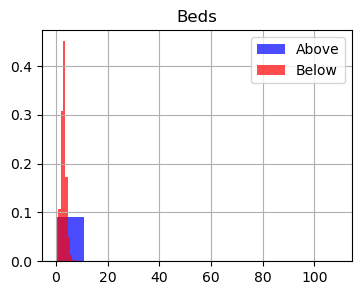

#################################################### END ####################################################

Comparing Price and Baths where Baths is the explanatory variable X and AboveBelowAverage is the dependant variable.



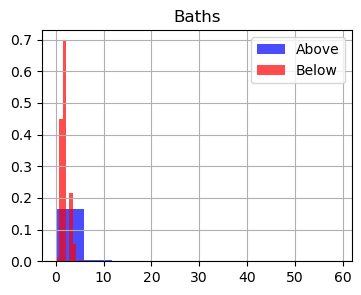

#################################################### END ####################################################

Comparing Price and Area where Area is the explanatory variable X and AboveBelowAverage is the dependant variable.



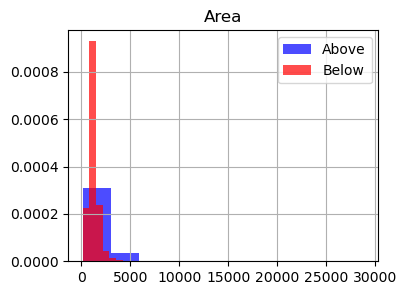

#################################################### END ####################################################

Comparing Price and PopulationLatest where PopulationLatest is the explanatory variable X and AboveBelowAverage is the dependant variable.



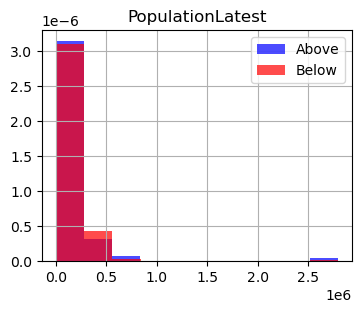

#################################################### END ####################################################

Comparing Price and Schools where Schools is the explanatory variable X and AboveBelowAverage is the dependant variable.



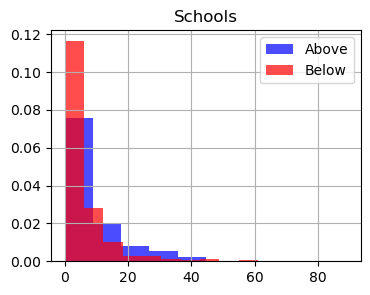

#################################################### END ####################################################

Comparing Price and Colleges where Colleges is the explanatory variable X and AboveBelowAverage is the dependant variable.



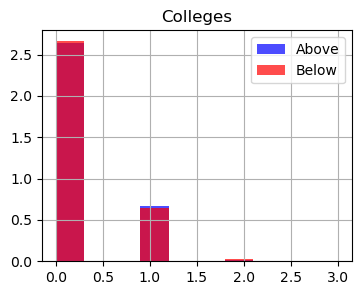

#################################################### END ####################################################

Comparing Price and Universities where Universities is the explanatory variable X and AboveBelowAverage is the dependant variable.



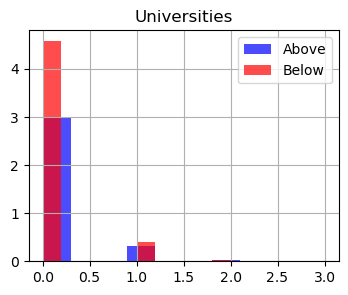

#################################################### END ####################################################

Comparing Price and Ameneties where Ameneties is the explanatory variable X and AboveBelowAverage is the dependant variable.



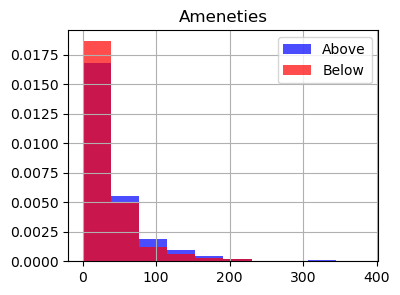

#################################################### END ####################################################

Comparing Price and Airbnbs where Airbnbs is the explanatory variable X and AboveBelowAverage is the dependant variable.



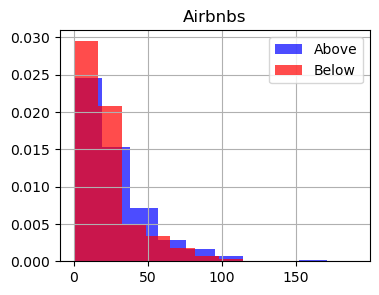

#################################################### END ####################################################

Comparing Price and Price where Price is the explanatory variable X and AboveBelowAverage is the dependant variable.



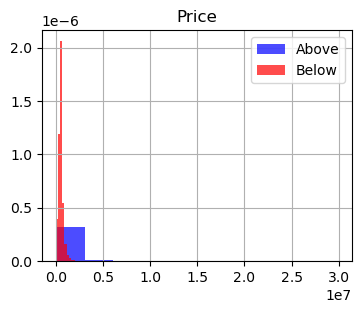

#################################################### END ####################################################

Comparing Price and AveragePrice where AveragePrice is the explanatory variable X and AboveBelowAverage is the dependant variable.



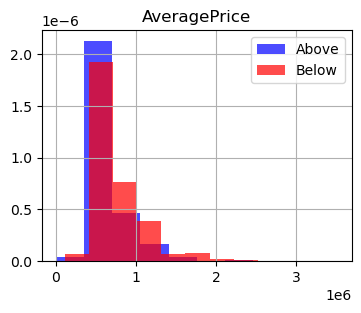

#################################################### END ####################################################

Comparing Price and ListingType_Condo where ListingType_Condo is the explanatory variable X and AboveBelowAverage is the dependant variable.



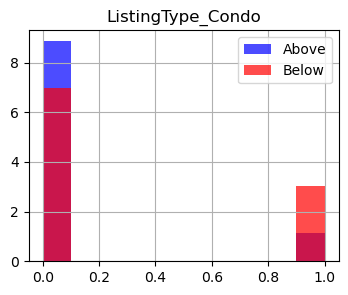

#################################################### END ####################################################

Comparing Price and ListingType_Condo/Townhome where ListingType_Condo/Townhome is the explanatory variable X and AboveBelowAverage is the dependant variable.



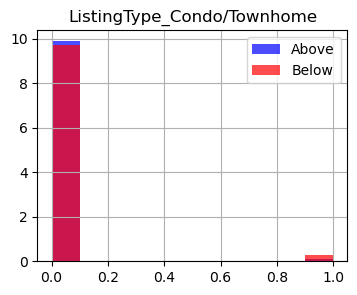

#################################################### END ####################################################

Comparing Price and ListingType_Farm where ListingType_Farm is the explanatory variable X and AboveBelowAverage is the dependant variable.



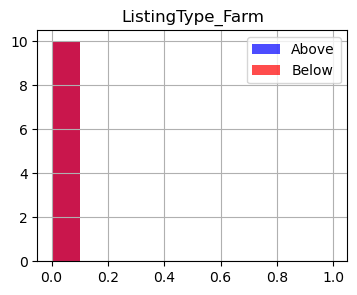

#################################################### END ####################################################

Comparing Price and ListingType_Multi-Family where ListingType_Multi-Family is the explanatory variable X and AboveBelowAverage is the dependant variable.



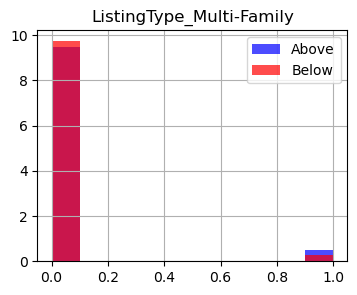

#################################################### END ####################################################

Comparing Price and ListingType_Single Family where ListingType_Single Family is the explanatory variable X and AboveBelowAverage is the dependant variable.



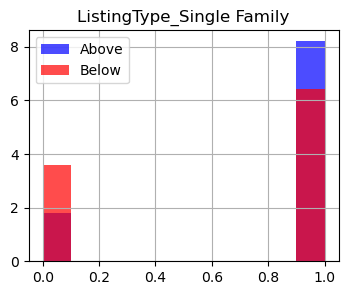

#################################################### END ####################################################



In [8]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np

for label in df_updated.columns[:-1]:
    if label != 'AboveBelowAverage' and 'ListingType_Townhome' not in label and 'CityName' not in label:
        warnings.simplefilter(action='ignore', category=FutureWarning)
        print(f'Comparing Price and {label} where {label} is the explanatory variable X and AboveBelowAverage is the dependant variable.\n')
        plt.figure(figsize=(4, 3))
        plt.title(label)
        plt.hist(df_updated[df_updated['AboveBelowAverage']==1][label], color='blue', label='Above', alpha=0.7, density=True)
        plt.hist(df_updated[df_updated['AboveBelowAverage']==0][label], color='red', label='Below', alpha=0.7, density=True)
        plt.legend()
        plt.grid(True)
        plt.show()
        print('#################################################### END ####################################################\n')


### Preparing Train, Validation and Test Datasets
> Below we will be dividing our data with different ratio for training, validation and testing respectively. The data will split using the following ratio:
> + Train: 60%
> + Validation: 20% (From 60% to 80%)
> + Testing: 20% (The left over data from 80% to 100%)

In [9]:
train, valid, test = np.split(df_updated.sample(frac=1), [int(0.6*len(df_updated)), int(0.8*len(df_updated))])

#### Preparing the data: 
> Part of data prepration process is to standardize and normalize the data for the following reasons:
>
> Standardization:
>
> + The goal of standardization is to rescale the features such that they have a mean of 0 and a standard deviation of 1. This is also known as z-score normalization.
> + Standardization is particularly useful when the features in your dataset have different scales. It helps algorithms that are sensitive to the scale of the features (e.g., gradient descent-based algorithms) converge faster and perform better
> 
> Normalization:
>
> + The goal of normalization is to rescale the features to a specific range, usually [0, 1].
> + Normalization is useful when the features have different ranges, and you want to bring them to a common scale. It is often used in algorithms that rely on distances or gradients and can be sensitive to the scale of the features.
>
> The following python modules are used for this:
> + numpy.hstack(): This function is used to stack the sequence of input arrays horizontally (i.e. column wise) to make a single array.
> + StandardScaler(): This will normalize the features i.e. each column of X, INDIVIDUALLY, so that each column/feature/variable will have μ = 0 and σ = 1.

In [10]:
from sklearn.preprocessing import StandardScaler

def scale_dataset(dataframe):
  X = dataframe[dataframe.columns[:-1]].values
  Y = dataframe[dataframe.columns[-1]].values
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  # Reshape the dataset
  data = np.hstack((X, np.reshape(Y, (-1, 1))))
  return data, X, Y

In [11]:
train, x_train, y_train = scale_dataset(df_updated)
valid, x_valid, y_valid = scale_dataset(df_updated)
test, x_test, y_test = scale_dataset(df_updated)

### Neural Networks

In [12]:
# Provided by Tensorflow

# Graph Plot Function to find the Loss
# with the given algorithm
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Binary crossentropy')
    plt.legend()
    plt.grid(True)
    plt.show()
# Graph Plot Function to find the Accuracy
# with the given algorithm
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_history(history):
    # Figure Configuration to show two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    # Plot one to visualize the loss from the history
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.grid(True)
    # Plot two to visualize the accuracy from the history
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    plt.show()


In [13]:
import tensorflow as tf

# Notes from Tensorflow's Documentation:
# 1. Sequential groups a linear stack of layers into a tf.keras.Model
# 2. Note that you can also omit the initial `Input`.
# 3. In that case the model doesn't have any weights until the first call
#    to a training/evaluation method (since it isn't yet built):
def train_model(x_train, y_train, num_nodes, dropout_prob, learning_rate, batch_size, epochs):
  nn_model = tf.keras.Sequential([
    # Input Layer
    tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(271,)),
    # To avoid overfitting
    tf.keras.layers.Dropout(dropout_prob),
    # Middle Layer
    tf.keras.layers.Dense(num_nodes, activation='relu'),
    # To avoid overfitting
    tf.keras.layers.Dropout(dropout_prob),
    # Output Layer
    tf.keras.layers.Dense(1, activation='sigmoid') 
    # Choosing Sigmoid activation for output data as 0 or 1.
  ])
  nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), 
                    loss='binary_crossentropy', metrics=['accuracy'])
  history = nn_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                         validation_split=0.2, verbose=0)
  
  return nn_model, history

Number Of Nodes: 16, Dropout: 0, Learning Rate: 0.1, Batch Size: 16


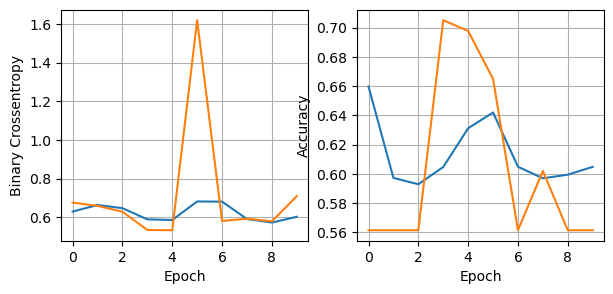

424/424 [==============================] - 1s 2ms/step - loss: 0.6346 - accuracy: 0.5911
Validation Loss of this model: 0.6345884203910828
################### END ###################

Number Of Nodes: 16, Dropout: 0, Learning Rate: 0.1, Batch Size: 32


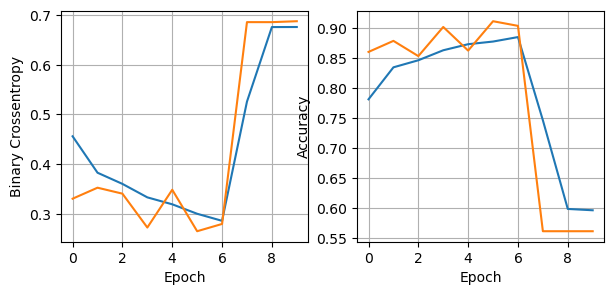

424/424 [==============================] - 1s 1ms/step - loss: 0.6765 - accuracy: 0.5911
Validation Loss of this model: 0.676453173160553
################### END ###################

Number Of Nodes: 16, Dropout: 0, Learning Rate: 0.1, Batch Size: 64


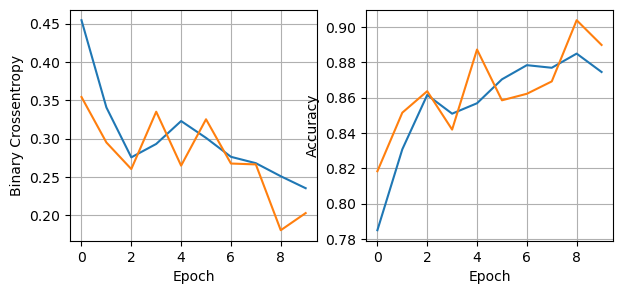

424/424 [==============================] - 1s 1ms/step - loss: 0.2143 - accuracy: 0.8680
Validation Loss of this model: 0.214319109916687
################### END ###################

Number Of Nodes: 16, Dropout: 0, Learning Rate: 0.005, Batch Size: 16


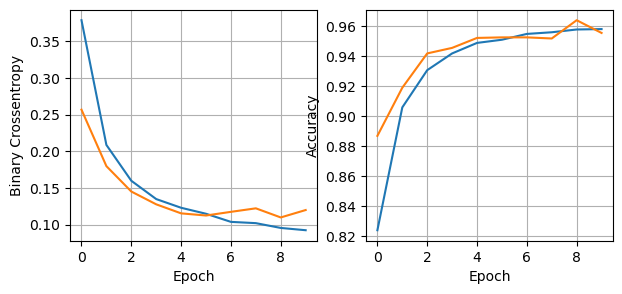

424/424 [==============================] - 1s 1ms/step - loss: 0.0827 - accuracy: 0.9644
Validation Loss of this model: 0.08272615075111389
################### END ###################

Number Of Nodes: 16, Dropout: 0, Learning Rate: 0.005, Batch Size: 32


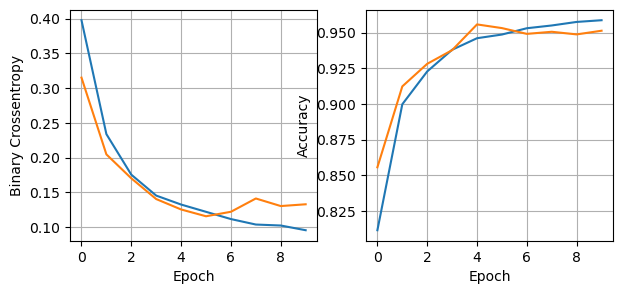

424/424 [==============================] - 1s 1ms/step - loss: 0.1039 - accuracy: 0.9580
Validation Loss of this model: 0.10392123460769653
################### END ###################

Number Of Nodes: 16, Dropout: 0, Learning Rate: 0.005, Batch Size: 64


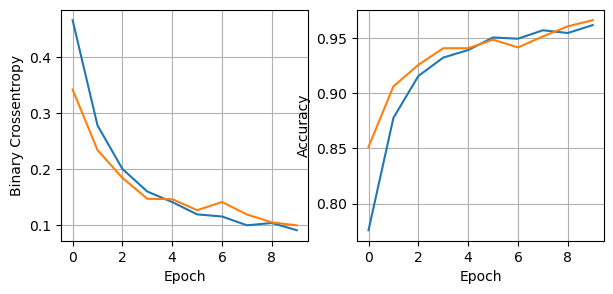

424/424 [==============================] - 1s 1ms/step - loss: 0.0796 - accuracy: 0.9699
Validation Loss of this model: 0.07956570386886597
################### END ###################

Number Of Nodes: 16, Dropout: 0, Learning Rate: 0.001, Batch Size: 16


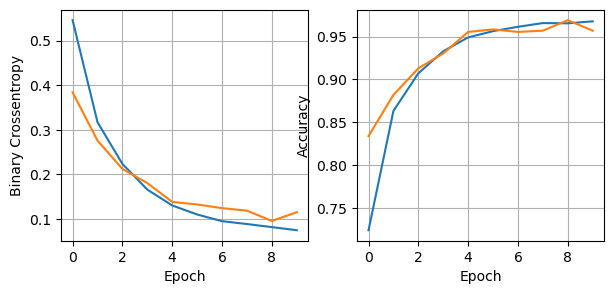

424/424 [==============================] - 1s 1ms/step - loss: 0.0851 - accuracy: 0.9628
Validation Loss of this model: 0.08512932807207108
################### END ###################

Number Of Nodes: 16, Dropout: 0, Learning Rate: 0.001, Batch Size: 32


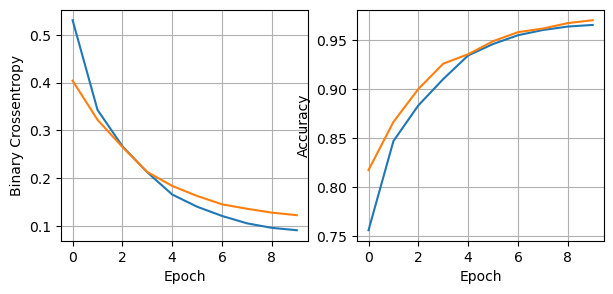

424/424 [==============================] - 1s 1ms/step - loss: 0.0839 - accuracy: 0.9752
Validation Loss of this model: 0.08394523710012436
################### END ###################

Number Of Nodes: 16, Dropout: 0, Learning Rate: 0.001, Batch Size: 64


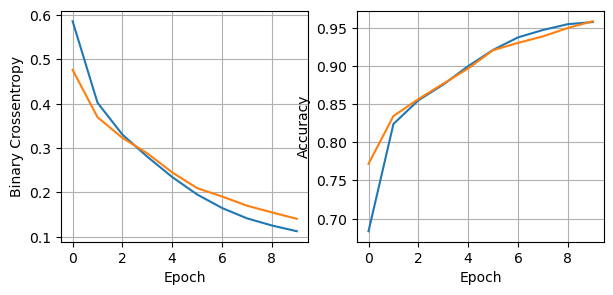

424/424 [==============================] - 1s 1ms/step - loss: 0.1071 - accuracy: 0.9621
Validation Loss of this model: 0.10711868107318878
################### END ###################

Number Of Nodes: 16, Dropout: 0.2, Learning Rate: 0.1, Batch Size: 16


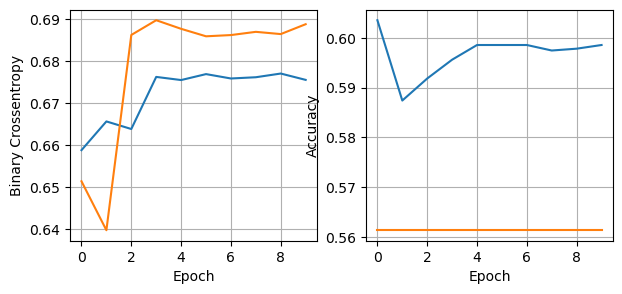

424/424 [==============================] - 1s 1ms/step - loss: 0.6766 - accuracy: 0.5911
Validation Loss of this model: 0.6766287684440613
################### END ###################

Number Of Nodes: 16, Dropout: 0.2, Learning Rate: 0.1, Batch Size: 32


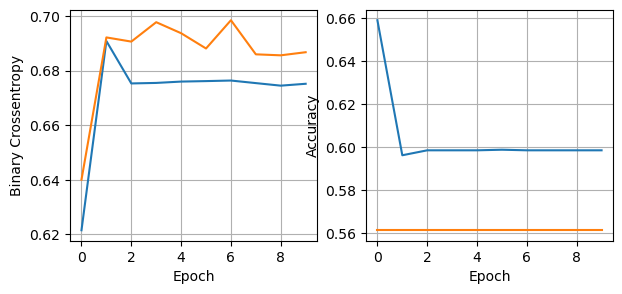

424/424 [==============================] - 1s 1ms/step - loss: 0.6823 - accuracy: 0.5911
Validation Loss of this model: 0.6822640299797058
################### END ###################

Number Of Nodes: 16, Dropout: 0.2, Learning Rate: 0.1, Batch Size: 64


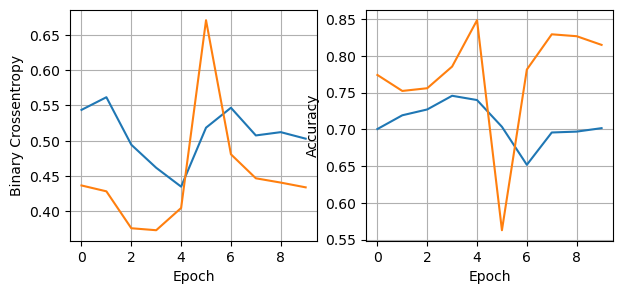

424/424 [==============================] - 1s 1ms/step - loss: 0.4371 - accuracy: 0.7839
Validation Loss of this model: 0.4370515048503876
################### END ###################

Number Of Nodes: 16, Dropout: 0.2, Learning Rate: 0.005, Batch Size: 16


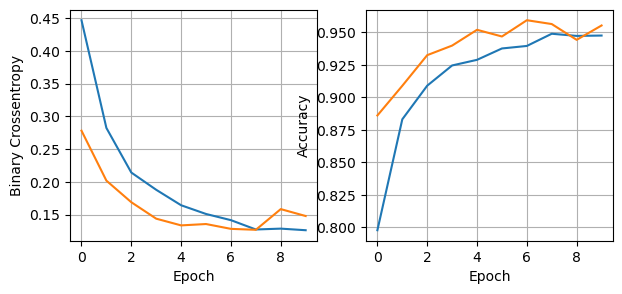

424/424 [==============================] - 1s 1ms/step - loss: 0.1065 - accuracy: 0.9585
Validation Loss of this model: 0.10651590675115585
################### END ###################

Number Of Nodes: 16, Dropout: 0.2, Learning Rate: 0.005, Batch Size: 32


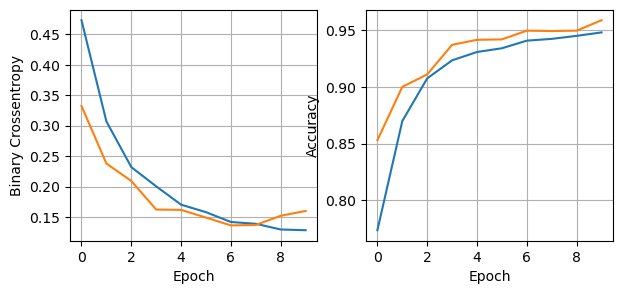

424/424 [==============================] - 1s 1ms/step - loss: 0.0985 - accuracy: 0.9630
Validation Loss of this model: 0.098511703312397
################### END ###################

Number Of Nodes: 16, Dropout: 0.2, Learning Rate: 0.005, Batch Size: 64


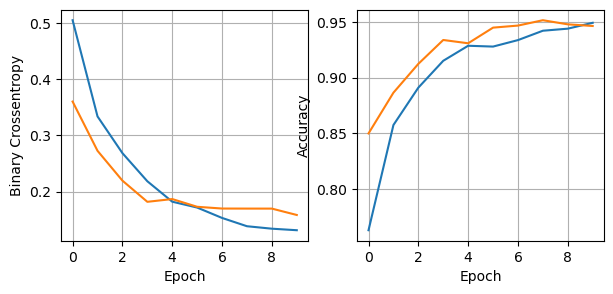

424/424 [==============================] - 1s 1ms/step - loss: 0.1102 - accuracy: 0.9554
Validation Loss of this model: 0.11022374033927917
################### END ###################

Number Of Nodes: 16, Dropout: 0.2, Learning Rate: 0.001, Batch Size: 16


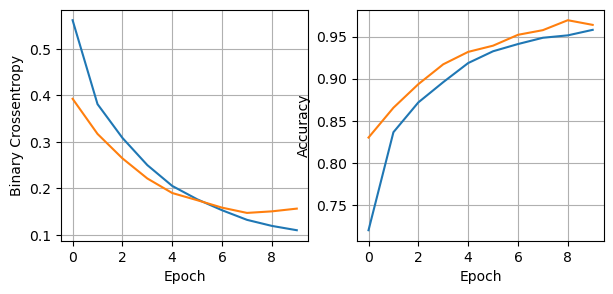

424/424 [==============================] - 1s 1ms/step - loss: 0.0855 - accuracy: 0.9722
Validation Loss of this model: 0.08550773561000824
################### END ###################

Number Of Nodes: 16, Dropout: 0.2, Learning Rate: 0.001, Batch Size: 32


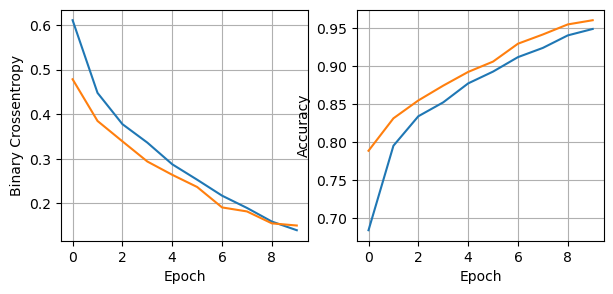

424/424 [==============================] - 1s 1ms/step - loss: 0.1020 - accuracy: 0.9685
Validation Loss of this model: 0.10202771425247192
################### END ###################

Number Of Nodes: 16, Dropout: 0.2, Learning Rate: 0.001, Batch Size: 64


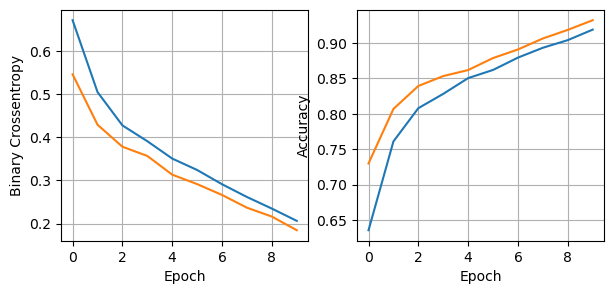

424/424 [==============================] - 1s 1ms/step - loss: 0.1516 - accuracy: 0.9442
Validation Loss of this model: 0.15158535540103912
################### END ###################

Number Of Nodes: 32, Dropout: 0, Learning Rate: 0.1, Batch Size: 16


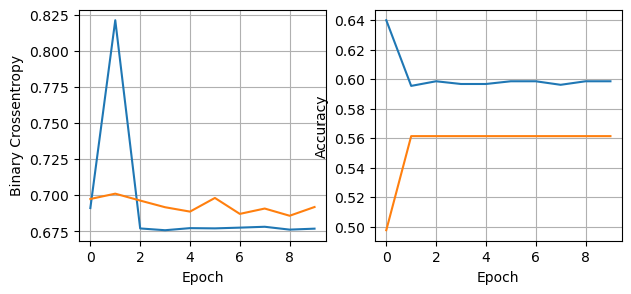

424/424 [==============================] - 1s 1ms/step - loss: 0.6778 - accuracy: 0.5911
Validation Loss of this model: 0.6777551174163818
################### END ###################

Number Of Nodes: 32, Dropout: 0, Learning Rate: 0.1, Batch Size: 32


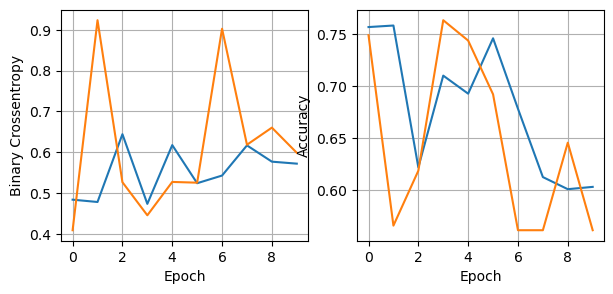

424/424 [==============================] - 1s 1ms/step - loss: 0.5813 - accuracy: 0.5911
Validation Loss of this model: 0.5812556147575378
################### END ###################

Number Of Nodes: 32, Dropout: 0, Learning Rate: 0.1, Batch Size: 64


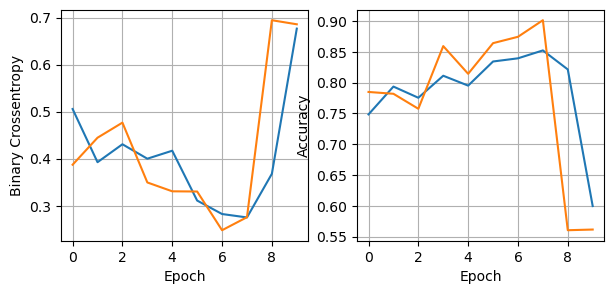

424/424 [==============================] - 1s 2ms/step - loss: 0.6773 - accuracy: 0.5911
Validation Loss of this model: 0.6772560477256775
################### END ###################

Number Of Nodes: 32, Dropout: 0, Learning Rate: 0.005, Batch Size: 16


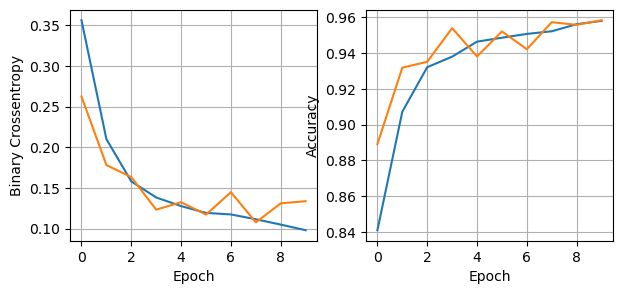

424/424 [==============================] - 1s 1ms/step - loss: 0.0955 - accuracy: 0.9611
Validation Loss of this model: 0.09551975131034851
################### END ###################

Number Of Nodes: 32, Dropout: 0, Learning Rate: 0.005, Batch Size: 32


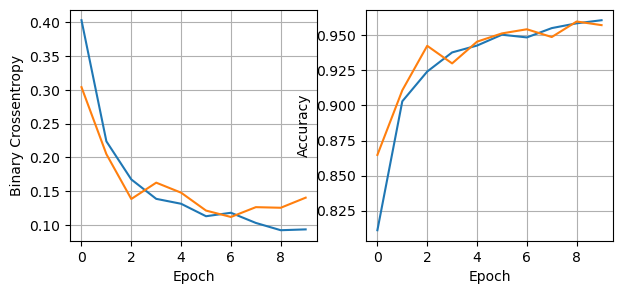

424/424 [==============================] - 1s 1ms/step - loss: 0.1040 - accuracy: 0.9627
Validation Loss of this model: 0.10404490679502487
################### END ###################

Number Of Nodes: 32, Dropout: 0, Learning Rate: 0.005, Batch Size: 64


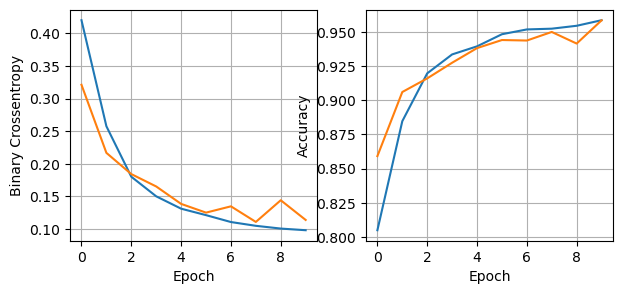

424/424 [==============================] - 1s 1ms/step - loss: 0.0887 - accuracy: 0.9615
Validation Loss of this model: 0.08873528242111206
################### END ###################

Number Of Nodes: 32, Dropout: 0, Learning Rate: 0.001, Batch Size: 16


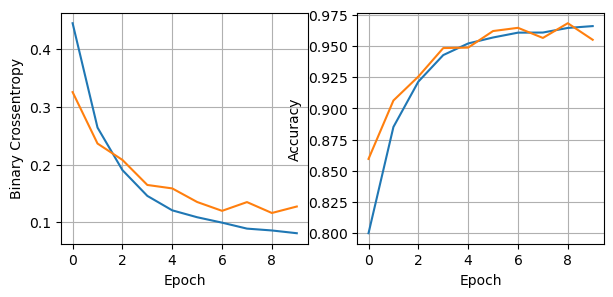

424/424 [==============================] - 1s 1ms/step - loss: 0.0925 - accuracy: 0.9619
Validation Loss of this model: 0.0925060585141182
################### END ###################

Number Of Nodes: 32, Dropout: 0, Learning Rate: 0.001, Batch Size: 32


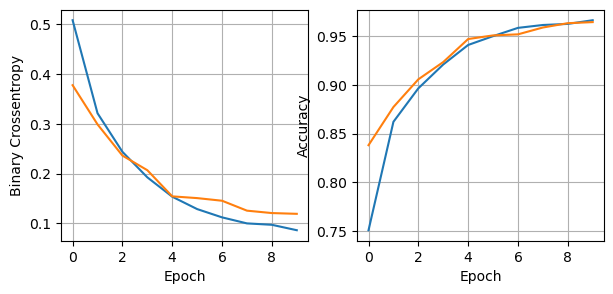

424/424 [==============================] - 1s 1ms/step - loss: 0.0869 - accuracy: 0.9700
Validation Loss of this model: 0.08685431629419327
################### END ###################

Number Of Nodes: 32, Dropout: 0, Learning Rate: 0.001, Batch Size: 64


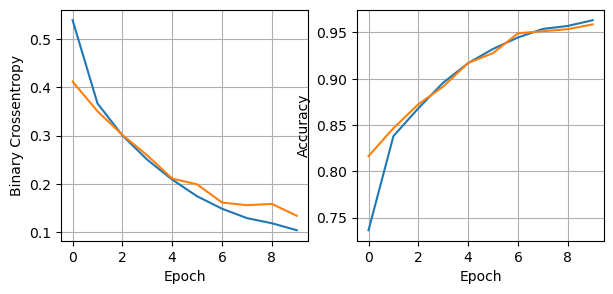

424/424 [==============================] - 1s 1ms/step - loss: 0.1023 - accuracy: 0.9649
Validation Loss of this model: 0.10233113914728165
################### END ###################

Number Of Nodes: 32, Dropout: 0.2, Learning Rate: 0.1, Batch Size: 16


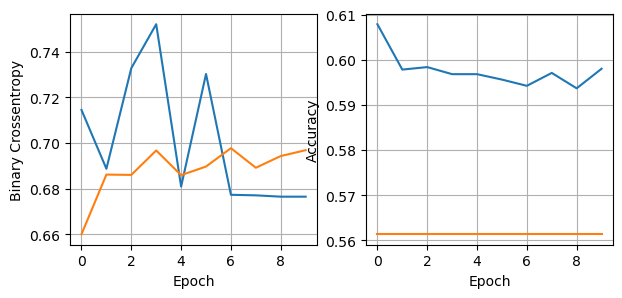

424/424 [==============================] - 1s 1ms/step - loss: 0.6804 - accuracy: 0.5911
Validation Loss of this model: 0.6804035305976868
################### END ###################

Number Of Nodes: 32, Dropout: 0.2, Learning Rate: 0.1, Batch Size: 32


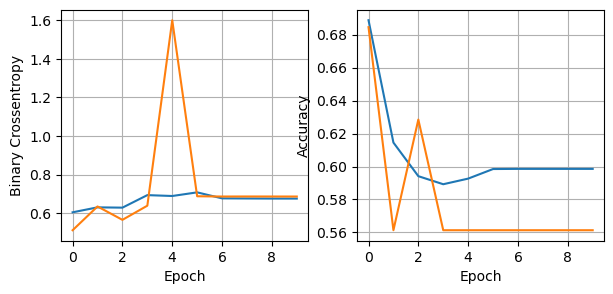

424/424 [==============================] - 1s 1ms/step - loss: 0.6793 - accuracy: 0.5911
Validation Loss of this model: 0.6792531609535217
################### END ###################

Number Of Nodes: 32, Dropout: 0.2, Learning Rate: 0.1, Batch Size: 64


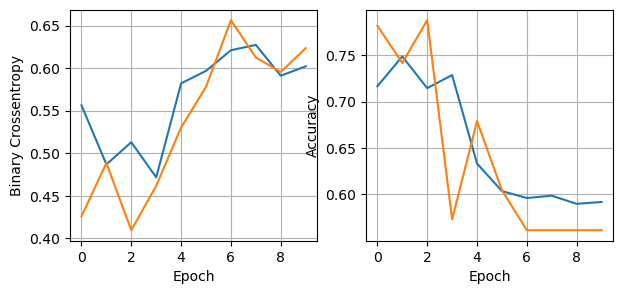

424/424 [==============================] - 1s 1ms/step - loss: 0.6119 - accuracy: 0.5911
Validation Loss of this model: 0.6118921041488647
################### END ###################

Number Of Nodes: 32, Dropout: 0.2, Learning Rate: 0.005, Batch Size: 16


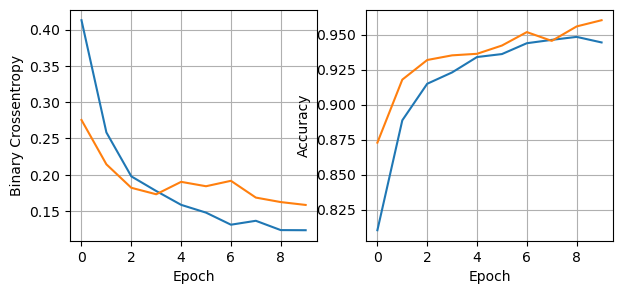

424/424 [==============================] - 1s 1ms/step - loss: 0.1025 - accuracy: 0.9633
Validation Loss of this model: 0.1024860367178917
################### END ###################

Number Of Nodes: 32, Dropout: 0.2, Learning Rate: 0.005, Batch Size: 32


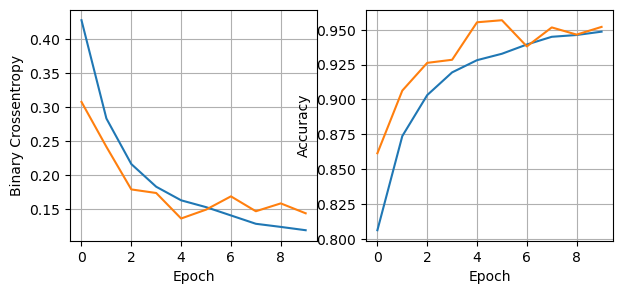

424/424 [==============================] - 1s 1ms/step - loss: 0.1046 - accuracy: 0.9542
Validation Loss of this model: 0.1046399399638176
################### END ###################

Number Of Nodes: 32, Dropout: 0.2, Learning Rate: 0.005, Batch Size: 64


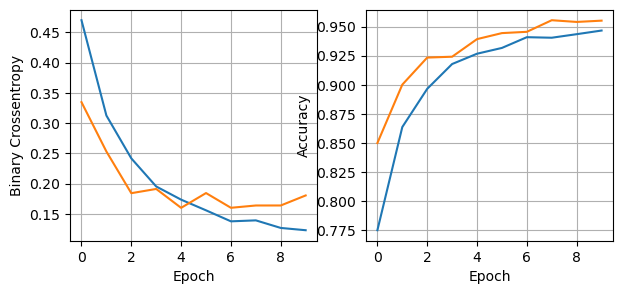

424/424 [==============================] - 1s 1ms/step - loss: 0.1117 - accuracy: 0.9601
Validation Loss of this model: 0.11173731088638306
################### END ###################

Number Of Nodes: 32, Dropout: 0.2, Learning Rate: 0.001, Batch Size: 16


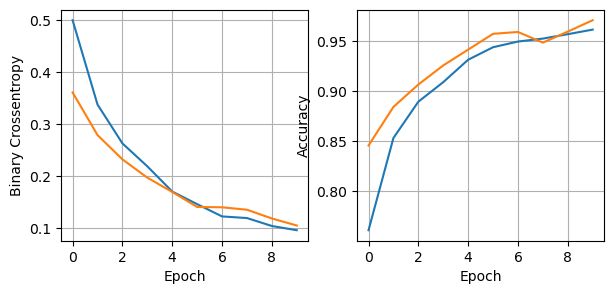

424/424 [==============================] - 1s 1ms/step - loss: 0.0738 - accuracy: 0.9732
Validation Loss of this model: 0.07378712296485901
################### END ###################

Number Of Nodes: 32, Dropout: 0.2, Learning Rate: 0.001, Batch Size: 32


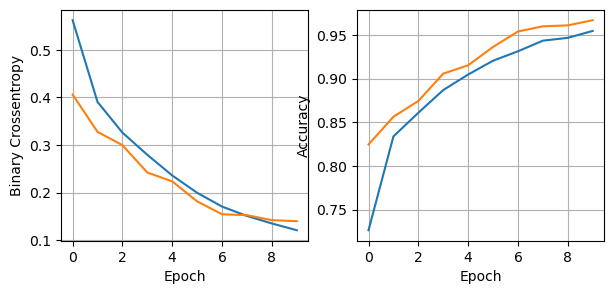

424/424 [==============================] - 1s 2ms/step - loss: 0.0921 - accuracy: 0.9713
Validation Loss of this model: 0.09210053831338882
################### END ###################

Number Of Nodes: 32, Dropout: 0.2, Learning Rate: 0.001, Batch Size: 64


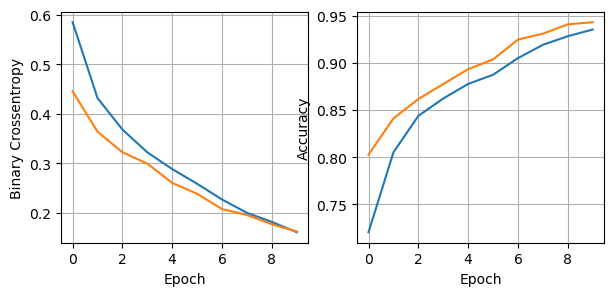

424/424 [==============================] - 1s 2ms/step - loss: 0.1215 - accuracy: 0.9576
Validation Loss of this model: 0.12153540551662445
################### END ###################

Number Of Nodes: 64, Dropout: 0, Learning Rate: 0.1, Batch Size: 16


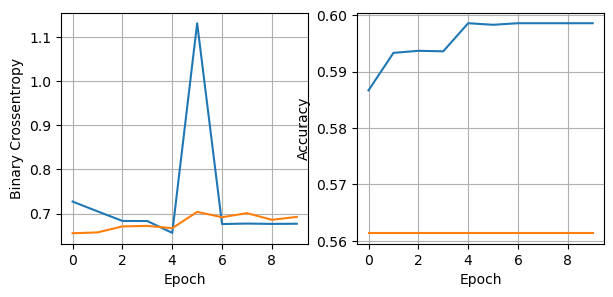

424/424 [==============================] - 1s 1ms/step - loss: 0.6780 - accuracy: 0.5911
Validation Loss of this model: 0.6779742240905762
################### END ###################

Number Of Nodes: 64, Dropout: 0, Learning Rate: 0.1, Batch Size: 32


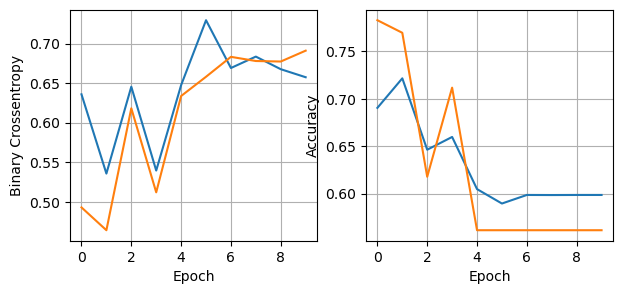

424/424 [==============================] - 1s 1ms/step - loss: 0.6670 - accuracy: 0.5911
Validation Loss of this model: 0.6669617891311646
################### END ###################

Number Of Nodes: 64, Dropout: 0, Learning Rate: 0.1, Batch Size: 64


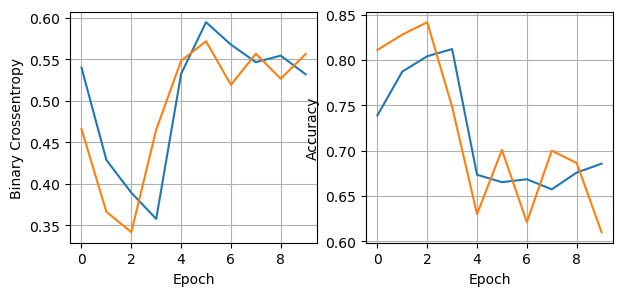

424/424 [==============================] - 1s 1ms/step - loss: 0.5302 - accuracy: 0.6397
Validation Loss of this model: 0.5301586985588074
################### END ###################

Number Of Nodes: 64, Dropout: 0, Learning Rate: 0.005, Batch Size: 16


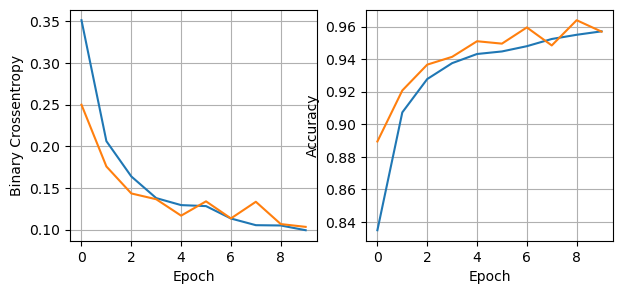

424/424 [==============================] - 1s 1ms/step - loss: 0.0959 - accuracy: 0.9592
Validation Loss of this model: 0.0958511084318161
################### END ###################

Number Of Nodes: 64, Dropout: 0, Learning Rate: 0.005, Batch Size: 32


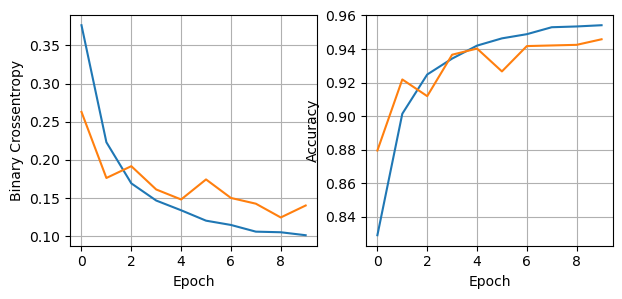

424/424 [==============================] - 1s 1ms/step - loss: 0.1114 - accuracy: 0.9543
Validation Loss of this model: 0.11144596338272095
################### END ###################

Number Of Nodes: 64, Dropout: 0, Learning Rate: 0.005, Batch Size: 64


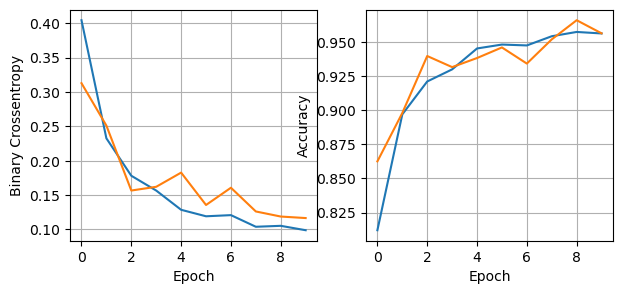

424/424 [==============================] - 1s 1ms/step - loss: 0.0837 - accuracy: 0.9656
Validation Loss of this model: 0.08374438434839249
################### END ###################

Number Of Nodes: 64, Dropout: 0, Learning Rate: 0.001, Batch Size: 16


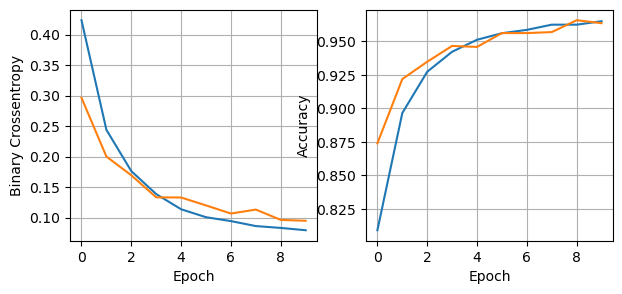

424/424 [==============================] - 1s 1ms/step - loss: 0.0709 - accuracy: 0.9718
Validation Loss of this model: 0.07085686177015305
################### END ###################

Number Of Nodes: 64, Dropout: 0, Learning Rate: 0.001, Batch Size: 32


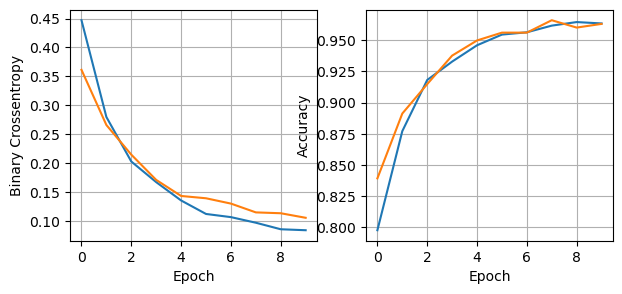

424/424 [==============================] - 1s 1ms/step - loss: 0.0782 - accuracy: 0.9686
Validation Loss of this model: 0.07819762080907822
################### END ###################

Number Of Nodes: 64, Dropout: 0, Learning Rate: 0.001, Batch Size: 64


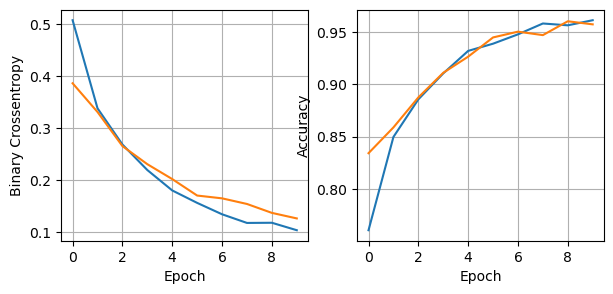

424/424 [==============================] - 1s 1ms/step - loss: 0.0948 - accuracy: 0.9650
Validation Loss of this model: 0.0947573110461235
################### END ###################

Number Of Nodes: 64, Dropout: 0.2, Learning Rate: 0.1, Batch Size: 16


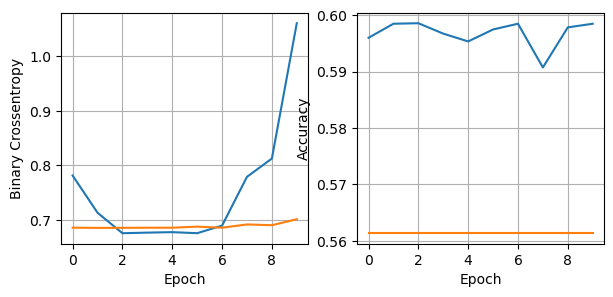

424/424 [==============================] - 1s 1ms/step - loss: 0.6833 - accuracy: 0.5911
Validation Loss of this model: 0.6833117604255676
################### END ###################

Number Of Nodes: 64, Dropout: 0.2, Learning Rate: 0.1, Batch Size: 32


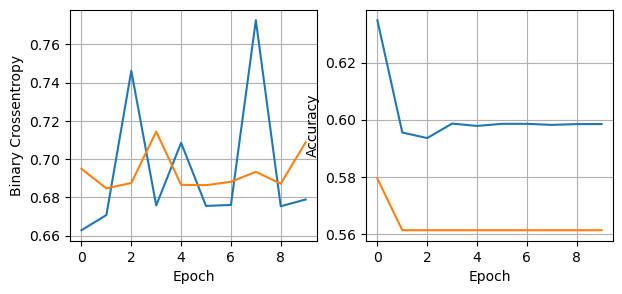

424/424 [==============================] - 1s 1ms/step - loss: 0.6883 - accuracy: 0.5911
Validation Loss of this model: 0.6883247494697571
################### END ###################

Number Of Nodes: 64, Dropout: 0.2, Learning Rate: 0.1, Batch Size: 64


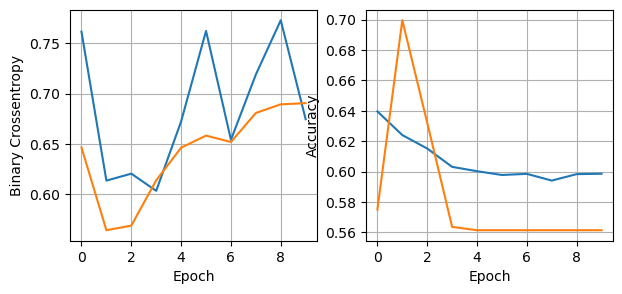

424/424 [==============================] - 1s 1ms/step - loss: 0.6772 - accuracy: 0.5911
Validation Loss of this model: 0.6771882176399231
################### END ###################

Number Of Nodes: 64, Dropout: 0.2, Learning Rate: 0.005, Batch Size: 16


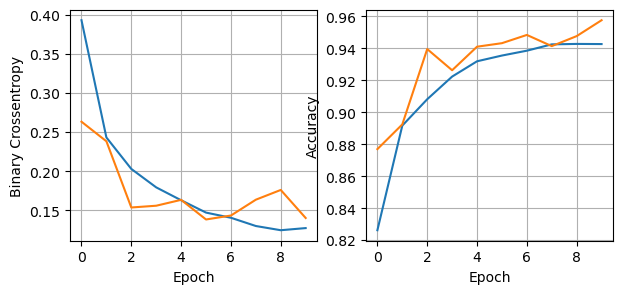

424/424 [==============================] - 1s 1ms/step - loss: 0.1138 - accuracy: 0.9522
Validation Loss of this model: 0.11378082633018494
################### END ###################

Number Of Nodes: 64, Dropout: 0.2, Learning Rate: 0.005, Batch Size: 32


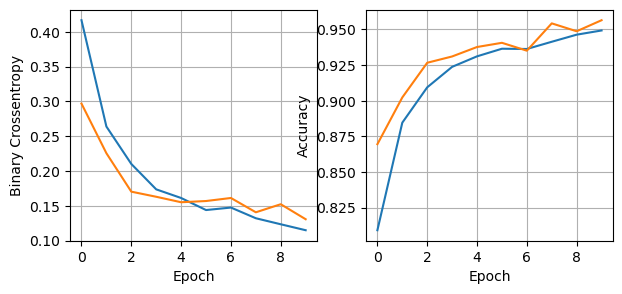

424/424 [==============================] - 1s 1ms/step - loss: 0.0970 - accuracy: 0.9648
Validation Loss of this model: 0.09696759283542633
################### END ###################

Number Of Nodes: 64, Dropout: 0.2, Learning Rate: 0.005, Batch Size: 64


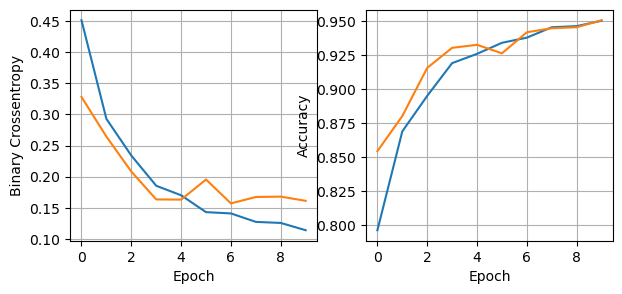

424/424 [==============================] - 1s 1ms/step - loss: 0.1014 - accuracy: 0.9617
Validation Loss of this model: 0.101387619972229
################### END ###################

Number Of Nodes: 64, Dropout: 0.2, Learning Rate: 0.001, Batch Size: 16


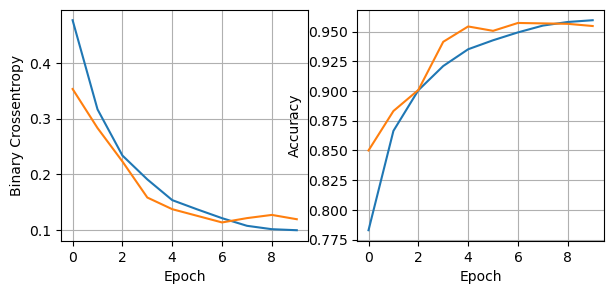

424/424 [==============================] - 1s 1ms/step - loss: 0.0795 - accuracy: 0.9708
Validation Loss of this model: 0.0794912800192833
################### END ###################

Number Of Nodes: 64, Dropout: 0.2, Learning Rate: 0.001, Batch Size: 32


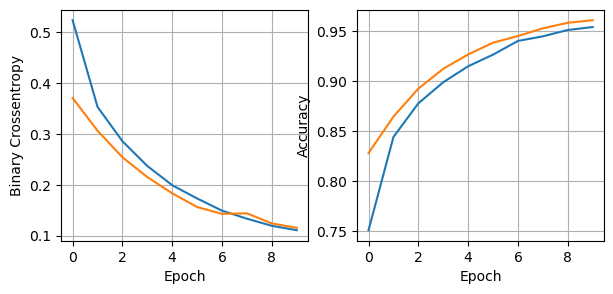

424/424 [==============================] - 1s 1ms/step - loss: 0.0849 - accuracy: 0.9679
Validation Loss of this model: 0.08492208272218704
################### END ###################

Number Of Nodes: 64, Dropout: 0.2, Learning Rate: 0.001, Batch Size: 64


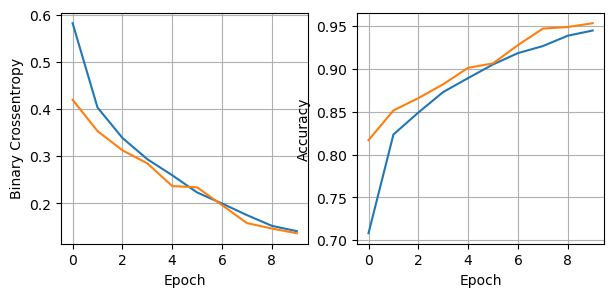

424/424 [==============================] - 1s 1ms/step - loss: 0.1055 - accuracy: 0.9625
Validation Loss of this model: 0.10550347715616226
################### END ###################



In [22]:
# Iterating over different set of hyperparameters 
# combination to find the optimal set of hyperparameters

# We initialize it as infinity knowing that 
# any model will beat that score
least_val_loss = float('inf')
# Initializing the least loss model variable
least_loss_model = None

epochs=10
for num_nodes in [16, 32, 64]:
  for dropout_prob in [0, 0.2]:
    for learning_rate in [0.1, 0.005, 0.001]:
      for batch_size in [16, 32, 64]:
        model, history = train_model(x_train, y_train, num_nodes,
                                     dropout_prob, learning_rate,
                                     batch_size, epochs)
        print(f'''Number Of Nodes: {num_nodes}, Dropout: {dropout_prob}, Learning Rate: {learning_rate}, Batch Size: {batch_size}''')
        plot_history(history)
        # Check the validation dataset loss is with different hyperparameters
        val_loss = model.evaluate(x_valid, y_valid)[0]
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = model
        print(f'Validation Loss of this model: {val_loss}')
        print('################### END ###################\n')

In [30]:
# Model with the following parameters has
# the least amount of validation loss:
# Number Of Nodes: 64, Dropout: 0, 
# Learning Rate: 0.001, Batch Size: 16

# Preparing the result to process it for
# the classification report.
y_predict = least_loss_model.predict(x_test)
y_predict = (y_predict > 0.5).astype(int).reshape(-1,)

424/424 [==============================] - 1s 1ms/step


In [31]:
from sklearn.metrics import classification_report
print('################ Classification Report ################\n')
print(classification_report(y_test, y_predict))
print('#######################################################\n')

################ Classification Report ################

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      5546
           1       0.98      0.98      0.98      8018

    accuracy                           0.97     13564
   macro avg       0.97      0.97      0.97     13564
weighted avg       0.97      0.97      0.97     13564

#######################################################



#### Understanding Classification Report

The report presents the main classification metrics—precision, recall, and F1-score—for each class. These metrics are calculated using true and false positives, along with true and false negatives. In this context, “positive” and “negative” are simply generic terms used for the predicted classes.
<br>
To assess whether a prediction is correct or incorrect, we consider four possible outcomes: <br>
1. <b>TN / True Negative: </b>The model correctly predicts a negative class for a negative case.
2. <b>TP / True Positive: </b>The model correctly predicts a positive class for a positive case.
3. <b>FN / False Negative: </b>The model incorrectly predicts a negative class for a positive case.
4. <b>FP / False Positive: </b>The model incorrectly predicts a positive class for a negative case.

##### Precision – What percent of your predictions were correct?

> Precision is the ability of a classifier not to label an instance positive that is actually negative. For each class it is defined as the ratio of true positives to the sum of true and false positives.

##### Recall – What percent of the positive cases did you catch? 
> Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives.
Recall: Fraction of positives that were correctly identified.

<img src="./images/Precisionrecall.svg.png" alt="Formula" width="300" height="600"/>

#### F1 score – What percent of positive predictions were correct? 
> The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.